In [1]:
# https://www.sc-best-practices.org/conditions/gsea_pathway.html#id380
# Kang HM, Subramaniam M, Targ S, et al. Multiplexed droplet single-cell RNA-sequencing using natural genetic variation
#   Nat Biotechnol. 2020 Nov;38(11):1356]. Nat Biotechnol. 2018;36(1):89-94. doi:10.1038/nbt.4042

In [1]:
model_kind = "ivae_random-0.1"
frac = 0.1

In [2]:
model_kind = str(model_kind)
frac = float(frac)

In [3]:
%load_ext autoreload
%autoreload 2

from pathlib import Path

import dotenv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import tensorflow as tf
from scipy.stats import weightedtau
from sklearn.model_selection import train_test_split

from isrobust_TFG.bio import (
    build_hipathia_renamers,
    get_adj_matrices,
    get_random_adj,
    get_reactome_adj,
    sync_gexp_adj,
)
from isrobust_TFG.datasets import load_kang
from isrobust_TFG.utils import set_all_seeds

project_path = Path(dotenv.find_dotenv()).parent

data_path = project_path.joinpath("data")
data_path.mkdir(exist_ok=True, parents=True)

set_all_seeds(seed=42)

tf.config.experimental.enable_op_determinism()

sc.set_figure_params(dpi=300, color_map="inferno")
sc.settings.verbosity = 1
sc.logging.print_header()

2025-02-10 08:44:02.348124: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1739177042.361054 1553851 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1739177042.364883 1553851 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-10 08:44:02.380348: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/sfernandez/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter

scanpy==1.10.4 anndata==0.11.3 umap==0.5.7 numpy==1.26.4 scipy==1.15.1 pandas==2.2.3 scikit-learn==1.6.1 statsmodels==0.14.4 igraph==0.10.8 pynndescent==0.5.13


In [4]:
config = dotenv.dotenv_values()
config

OrderedDict([('IVAE_ENV_FOLDER', './.venvs/ivae'),
             ('BINN_ENV_FOLDER', './.venvs/binn'),
             ('N_GPU', '3'),
             ('N_CPU', '20'),
             ('SEED', '42'),
             ('SEED_START', '0'),
             ('SEED_STOP', '50'),
             ('SEED_STEP', '1'),
             ('DEBUG', '1'),
             ('FRAC_START', '0.05'),
             ('FRAC_STOP', '0.85'),
             ('FRAC_STEP', '0.2'),
             ('RESULTS_FOLDER', 'path')])

In [5]:
debug = bool(int(config["DEBUG"]))

results_path = Path(config["RESULTS_FOLDER"])
results_path.mkdir(exist_ok=True, parents=True)
figs_path = results_path.joinpath("figs")
figs_path.mkdir(exist_ok=True, parents=True)
tables_path = results_path.joinpath("tables")
tables_path.mkdir(exist_ok=True, parents=True)

In [6]:
seeds = list(
    range(
        int(config["SEED_START"]),
        int(config["SEED_STOP"]) + 1,
        int(config["SEED_STEP"]),
    )
)
N_ITERS = len(seeds)

In [7]:
if debug:
    N_EPOCHS = 2
else:
    N_EPOCHS = 300

if model_kind == "ivae_kegg":
    n_encoding_layers = 3
elif model_kind == "ivae_reactome":
    n_encoding_layers = 2
elif "ivae_random" in model_kind:
    n_encoding_layers = 2
else:
    raise NotImplementedError(f"{model_kind} not implemented yet.")

print(f"{debug=} {model_kind=}")

debug=True model_kind='ivae_random-0.1'


In [8]:
if "ivae_random" in model_kind:
    n_genes = 3000
else:
    n_genes = None
adata = load_kang(data_folder=data_path, normalize=True, n_genes=n_genes)

/home/sfernandez/TFG/robustness_informed_TFG/isrobust_TFG/datasets.py:18: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  adata.obs["label"] = adata.obs["label"].replace(


In [9]:
x_trans = adata.to_df()

In [10]:
circuit_adj, circuit_to_pathway_adj = get_adj_matrices(
    gene_list=x_trans.columns.to_list()
)

circuit_renamer, pathway_renamer, circuit_to_effector = build_hipathia_renamers()

kegg_circuit_names = circuit_adj.rename(columns=circuit_renamer).columns

kegg_pathway_names = circuit_to_pathway_adj.rename(columns=pathway_renamer).columns

circuit_adj.head()

circuit,P-hsa03320-62,P-hsa03320-45,P-hsa03320-43,P-hsa03320-23,P-hsa03320-32,P-hsa03320-8,P-hsa03320-7,P-hsa03320-9,P-hsa03320-39,P-hsa03320-38,...,P-hsa05164-41.42,P-hsa05164-47,P-hsa05164-53,P-hsa05164-65.66,P-hsa05164-68,P-hsa05164-70,P-hsa05164-77,P-hsa05164-78,P-hsa05164-90,P-hsa05164-99
symbol,,,,,,,,,,,,,,,,,,,,,
TANK,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
NR1H3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
PPIF,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
LPAR6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CDK4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [11]:
reactome = get_reactome_adj()
reactome_pathway_names = reactome.columns

In [12]:
if model_kind == "ivae_kegg":
    x_trans, circuit_adj = sync_gexp_adj(gexp=x_trans, adj=circuit_adj)
elif model_kind == "ivae_reactome":
    x_trans, reactome = sync_gexp_adj(x_trans, reactome)

In [13]:
state = np.random.get_state()

# we ensure to presever the same sparsity structure for a given frac across all seeds
random_layer, random_layer_names = get_random_adj(
    frac, shape=reactome.shape, size=reactome.size, index=reactome.index, seed=0
)

np.random.set_state(state)

In [14]:
if model_kind == "ivae_kegg":
    x_trans, circuit_adj = sync_gexp_adj(gexp=x_trans, adj=circuit_adj)
elif model_kind == "ivae_reactome":
    x_trans, reactome = sync_gexp_adj(x_trans, reactome)
elif "ivae_random" in model_kind:
    x_trans, random_layer = sync_gexp_adj(x_trans, random_layer)

In [15]:
def get_importances(data, abs=False):
    if abs:
        return np.abs(data).mean(axis=0)
    else:
        return data.mean(axis=0)


def get_activations(act_model, layer_id, data):
    data_encoded = act_model.predict(data)[layer_id]
    return data_encoded

In [16]:
def train_val_test_split(features, val_size, test_size, stratify, seed):
    train_size = 1 - (val_size + test_size)

    x_train, x_test, y_train, y_test = train_test_split(
        features,
        stratify,
        train_size=train_size,
        stratify=stratify,
        random_state=seed,
    )

    x_val, x_test = train_test_split(
        x_test,
        test_size=test_size / (test_size + val_size),
        stratify=y_test,
        random_state=seed,
    )

    x_train = x_train.astype("float32")
    x_val = x_val.astype("float32")
    x_test = x_test.astype("float32")

    return x_train, x_val, x_test

In [17]:
results_path_model = results_path.joinpath(model_kind)
obs = adata.obs.copy()
results_path_model.mkdir(exist_ok=True, parents=True)
results_path_model_seed = results_path_model.joinpath("seed_" + str(seed))
obs = adata.obs.copy()
results_path_model_model.mkdir(exist_ok=True, parents=True)

NameError: name 'seed' is not defined

In [ ]:
if model_kind == "ivae_kegg":
    # vae, encoder, decoder = build_kegg_vae(
    #     circuits=circuit_adj, pathways=circuit_to_pathway_adj, seed=42
    # )
    layer_ids = [1, 2, 3]
elif model_kind == "ivae_reactome":
    # vae, encoder, decoder = build_reactome_vae(reactome, seed=42)
    layer_ids = [1, 2]
elif "ivae_random" in model_kind:
    # vae, encoder, decoder = build_reactome_vae(random_layer, seed=42)
    layer_ids = [1, 2]
else:
    raise NotImplementedError("Model not yet implemented.")

In [18]:
non_layer_names = ["split", "layer", "seed", "cell_type", "condition", "model"]

In [19]:
results_path_model

PosixPath('path/ivae_random-0.1')

In [20]:
scores_metrics = [
    pd.read_pickle(results_path_model_seed.joinpath(f"metrics-seed-{seed:02d}.pkl"))
    for seed in seeds
]
scores_metrics = pd.concat(scores_metrics, axis=0, ignore_index=True)
scores_metrics.to_pickle(results_path_model_seed.joinpath("scores_metrics.pkl"))

scores_metrics.head()

NameError: name 'results_path_model_seed' is not defined

In [21]:
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(context="paper", font_scale=0.5, style="ticks", rc=custom_params)

g = sns.catplot(
    data=scores_metrics,
    kind="violin",
    col="metric",
    height=2,
    aspect=0.9,
    sharey=False,
    x="model",
    y="score",
    hue="split",
    split=False,
    cut=0,
    fill=False,
    density_norm="count",
    inner="quart",
    linewidth=0.5,
)

NameError: name 'scores_metrics' is not defined

In [22]:
scores_informed = {}

for layer_id in layer_ids:
    if results_path_model_seed.joinpath(
        f"encodings_layer-{layer_id:02d}_seed-00.pkl"
    ).exists():
        results_layer = [
            pd.read_pickle(
                results_path_model_seed.joinpath(
                    f"encodings_layer-{layer_id:02d}_seed-{seed:02d}.pkl"
                )
            )
            for seed in seeds
        ]
    else:
        continue

    scores_informed[layer_id] = {}
    for split in ["train", "test", "val"]:
        results = [
            x.loc[x["split"] == split].drop(non_layer_names, axis=1)
            for x in results_layer
        ]
        scores_informed[layer_id][split] = []
        for seed_i in seeds:
            for seed_j in range(seed_i + 1, N_ITERS):
                scores_informed[layer_id][split].append(
                    weightedtau(
                        get_importances(data=results[seed_i], abs=True),
                        get_importances(data=results[seed_j], abs=True),
                    )[0]
                )

NameError: name 'layer_ids' is not defined

In [26]:
scores_informed = (
    pd.DataFrame.from_dict(scores_informed)
    .melt(var_name="layer", value_name="score", ignore_index=False)
    .reset_index(names=["split"])
    .explode("score")
)
scores_informed["score"] = scores_informed["score"].astype("float")
scores_informed["model"] = model_kind
scores_informed.to_pickle(results_path_model_seed.joinpath("scores_informed.pkl"))

In [40]:
results_path_model_seed.joinpath("scores_informed.pkl")

PosixPath('/home/aesteban/expanse/TFM/results/ivae_random-0.10/scores_informed.pkl')

In [27]:
scores_informed.head()

,split,layer,score,model
0,train,1,1.0,ivae_random-0.10
0,train,1,1.0,ivae_random-0.10
0,train,1,1.0,ivae_random-0.10
0,train,1,1.0,ivae_random-0.10
0,train,1,1.0,ivae_random-0.10


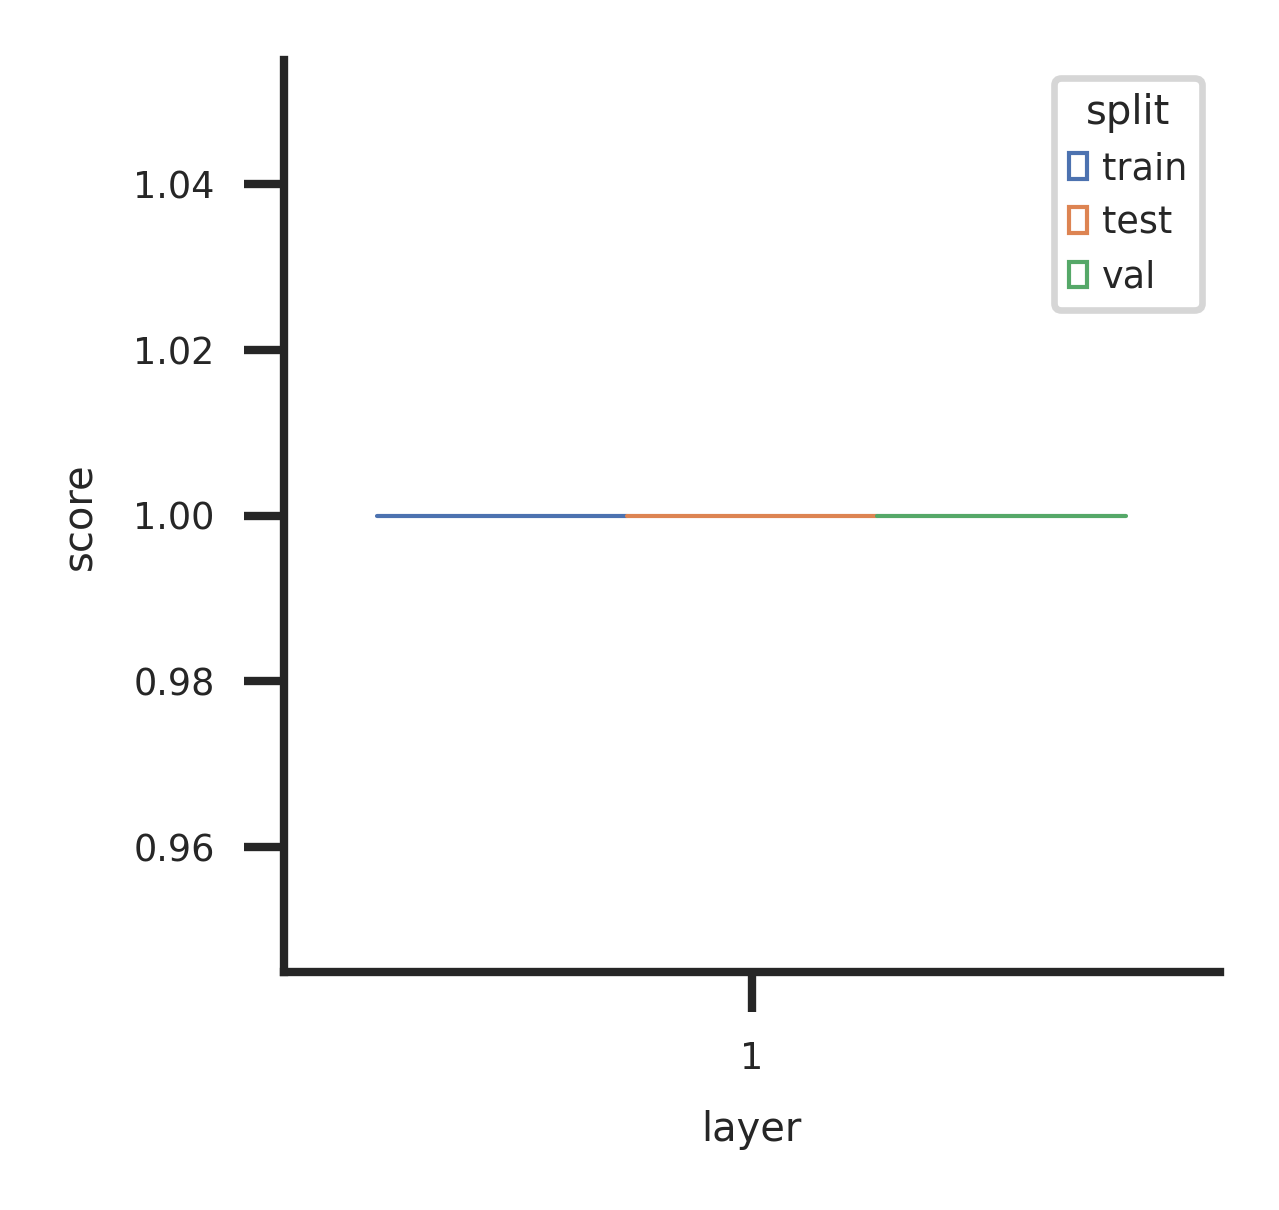

In [28]:
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(context="paper", font_scale=0.5, style="ticks", rc=custom_params)
plt.figure(figsize=(2, 2))
sns.violinplot(
    data=scores_informed,
    x="layer",
    y="score",
    hue="split",
    split=False,
    cut=0,
    fill=False,
    density_norm="count",
    inner="quart",
    linewidth=0.5,
)
sns.despine()

In [29]:
from multiprocessing import cpu_count

from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics.cluster import adjusted_mutual_info_score

batch_size = 256 * cpu_count() + 1

In [ ]:
clust_scores = {}

for layer_id in layer_ids:
    if results_path_model_seed.joinpath(
        f"encodings_layer-{layer_id:02d}_seed-00.pkl"
    ).exists():
        results_layer = [
            pd.read_pickle(
                results_path_model_seed.joinpath(
                    f"encodings_layer-{layer_id:02d}_seed-{seed:02d}.pkl"
                )
            )
            for seed in range(N_ITERS)
        ]
    else:
        continue

    train_embeddings_lst = [
        x.loc[(x["split"] == "train") & (x["condition"] == "control")]
        for x in results_layer
    ]
    val_embeddings_lst = [
        x.loc[(x["split"] == "val") & (x["condition"] == "control")]
        for x in results_layer
    ]
    test_embeddings_lst = [
        x.loc[(x["split"] == "test") & (x["condition"] == "control")]
        for x in results_layer
    ]

    clust_scores[layer_id] = {}
    clust_scores[layer_id]["train"] = []
    clust_scores[layer_id]["val"] = []
    clust_scores[layer_id]["test"] = []

    for seed in range(N_ITERS):
        y_train = train_embeddings_lst[seed]["cell_type"]
        y_val = val_embeddings_lst[seed]["cell_type"]
        y_test = test_embeddings_lst[seed]["cell_type"]

        train_embeddings = train_embeddings_lst[seed].drop(non_layer_names, axis=1)
        val_embeddings = val_embeddings_lst[seed].drop(non_layer_names, axis=1)
        test_embeddings = test_embeddings_lst[seed].drop(non_layer_names, axis=1)

        model = MiniBatchKMeans(n_clusters=y_train.nunique(), batch_size=batch_size)
        model.fit(train_embeddings)
        clust_scores[layer_id]["train"].append(
            adjusted_mutual_info_score(y_train, model.labels_)
        )
        clust_scores[layer_id]["val"].append(
            adjusted_mutual_info_score(y_val, model.predict(val_embeddings))
        )
        clust_scores[layer_id]["test"].append(
            adjusted_mutual_info_score(y_test, model.predict(test_embeddings))
        )

In [39]:
results_path_model_seed.joinpath("scores_clustering.pkl")

PosixPath('/home/aesteban/expanse/TFM/results/ivae_random-0.10/scores_clustering.pkl')

In [37]:
clust_scores = (
    pd.DataFrame.from_dict(clust_scores)
    .melt(var_name="layer", value_name="score", ignore_index=False)
    .reset_index(names=["split"])
    .explode("score")
)
clust_scores["score"] = clust_scores["score"].astype("float")
clust_scores["model"] = model_kind
clust_scores.to_pickle(results_path_model_seed.joinpath("scores_clustering.pkl"))

ValueError: value_name (score) cannot match an element in the DataFrame columns.

In [36]:
clust_scores.head()

,split,layer,score,model
0,train,1,0.834083,ivae_random-0.10
0,train,1,0.723655,ivae_random-0.10
0,train,1,0.780400,ivae_random-0.10
0,train,1,0.726538,ivae_random-0.10
0,train,1,0.737371,ivae_random-0.10


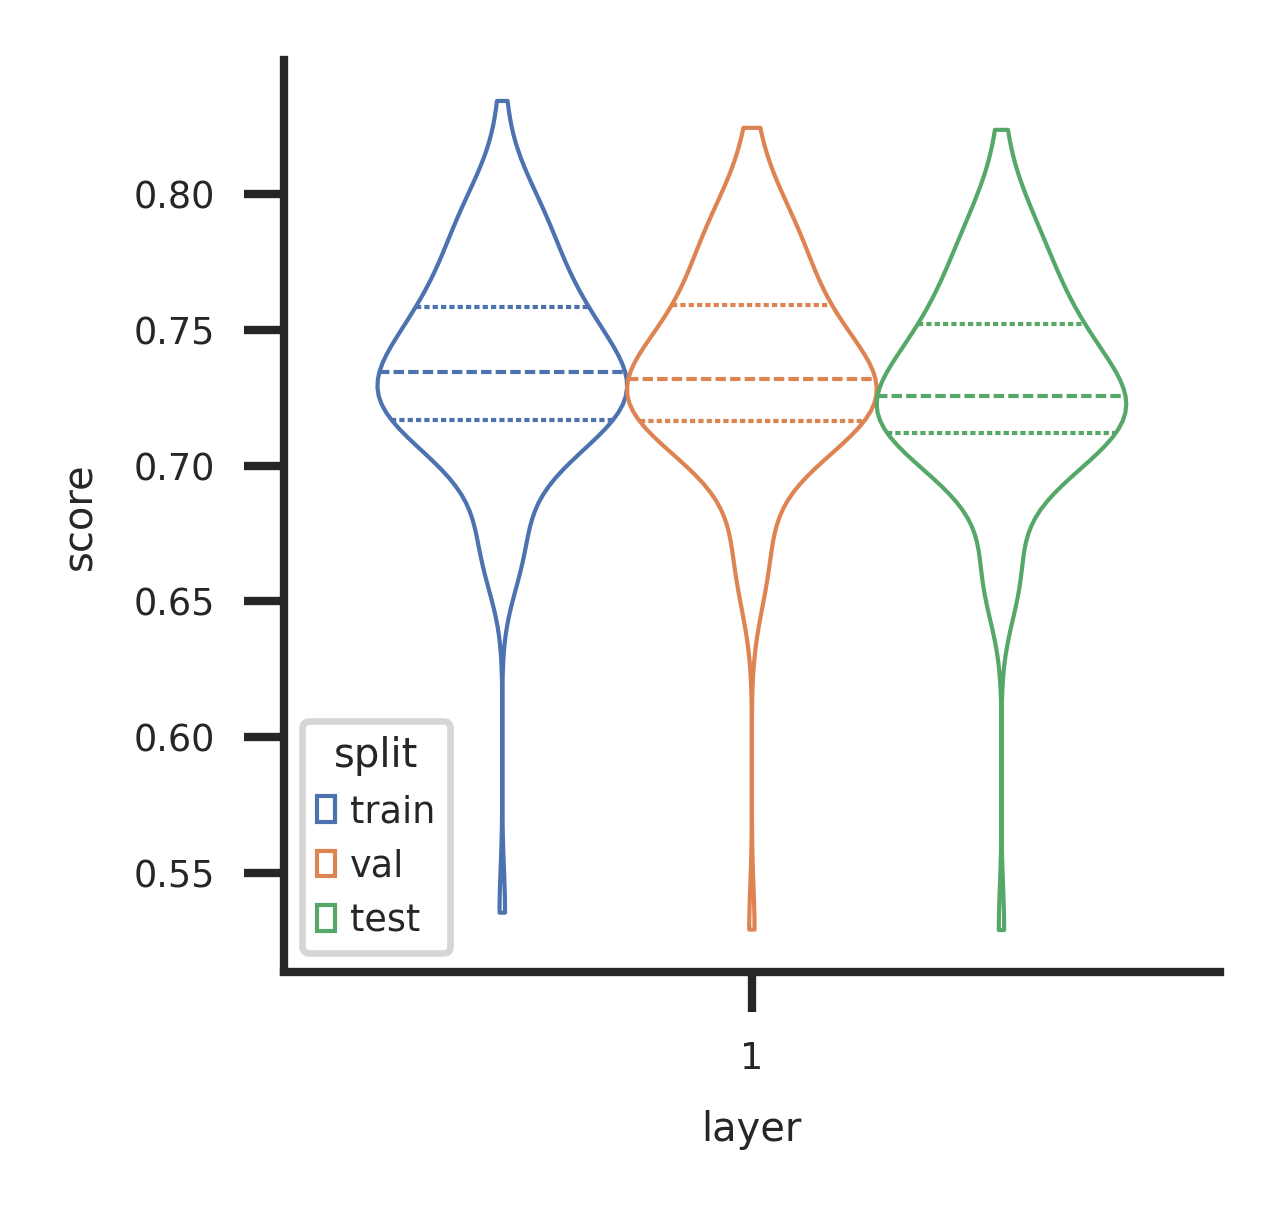

In [35]:
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(context="paper", font_scale=0.5, style="ticks", rc=custom_params)
plt.figure(figsize=(2, 2))
sns.violinplot(
    data=clust_scores,
    x="layer",
    y="score",
    hue="split",
    split=False,
    cut=0,
    fill=False,
    density_norm="count",
    inner="quart",
    linewidth=0.5,
)
sns.despine()